# Projet Fraude 



In [1]:
import warnings
warnings.simplefilter('ignore')
#autres
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

### Importer les dataset

In [2]:
#target --> class : 1 Fraud | 0 ok 

dataFraud = pd.read_csv('Fraud_Data.csv')
#ataFraud = dataFraud.head(5000)
dataFraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
dataIp = pd.read_csv('IpAddress_to_Country.csv')
dataIp.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


### Créer une nouvelle colonne `country` en effectuant une jointure entre les deux dataset 

In [153]:
#df = dataFraud.join(dataIp, lsuffix='ip_address', rsuffix='interval')
#df 

#s = pd.IntervalIndex.from_arrays(dataIp.lower_bound_ip_address, dataIp.upper_bound_ip_address, 'both')
#dataFraud.assign(country=dataIp.set_index(s).loc[dataFraud.ip_address].country.values)
#dataIp = dataIp.set_index(s)



In [4]:
countries = len(dataFraud) * [0]

for i, row in dataFraud.iterrows():
        tmp = dataIp[(dataIp['lower_bound_ip_address'] < row['ip_address']) & (dataIp['upper_bound_ip_address'] > row['ip_address'])]['country']   
        if len(tmp) == 1:
            countries[i] = tmp.values[0]
        dataFraud['country'] = countries



In [5]:
dataFraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


### Créer une nouvelle variable `time_diff` qui sera la différence entre les variables `purchase_time` et `signup_time`

In [6]:
dataFraud['time_diff'] = pd.to_datetime(dataFraud['purchase_time']) - pd.to_datetime(dataFraud['signup_time'])
dataFraud['time_diff'] = dataFraud['time_diff'].astype('timedelta64[s]')

In [7]:
dataFraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0,492085.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0


### Regroupper les `user_id` par `device_id`  afin d'avoir le nombre de device par client  

In [8]:
#dataFraud.groupby('user_id')
#dataFraud['device_num'] = dataFraud['device_id'].value_counts()
device_num = dataFraud.groupby('device_id')['user_id'].count()
device_num = device_num[dataFraud['device_id']]
device_num = device_num.reset_index().drop('device_id', axis = 1)
dataFraud['device_num'] = device_num
dataFraud.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0,492085.0,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1


### Faire de même pour les `ip_address` 

In [9]:
ip_num = dataFraud.groupby('ip_address')['user_id'].count()
ip_num = ip_num[dataFraud['ip_address']]
ip_num = ip_num.reset_index().drop('ip_address', axis = 1)
dataFraud['ip_num'] = ip_num
dataFraud.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0,492085.0,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1,1


### Traiter les variables `signup_time` & `purchase_time` afin de les différentier suivant la semaine et le week end  

In [10]:
#
dataFraud['signup_time'] = pd.to_datetime(dataFraud['signup_time'])
dataFraud['purchase_time'] = pd.to_datetime(dataFraud['purchase_time'])
dataFraud['signup_day'] = dataFraud['signup_time'].dt.dayofweek
dataFraud['signup_week'] = dataFraud['signup_time'].dt.week
dataFraud['purchase_day'] = dataFraud['purchase_time'].dt.dayofweek
dataFraud['purchase_week'] = dataFraud['purchase_time'].dt.week
dataFraud

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,0,492085.0,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,1,1,1,30,2,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1,United States,5261233.0,2,1,1,5,6,13
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,Netherlands,931270.0,1,1,4,20,1,22
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,Japan,6681616.0,1,1,1,10,2,21
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0,United States,5146119.0,2,1,3,28,0,37


### Définir vos variables de travail (X,y)

In [11]:
df = dataFraud[['signup_day','signup_week','purchase_day','purchase_week','purchase_value','source','browser','sex','age','country','time_diff','device_num','ip_num','class']]
df

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,4506682.0,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944.0,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1.0,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,0,492085.0,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,4361461.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,1,5,6,13,43,SEO,Chrome,M,28,United States,5261233.0,2,1,1
151108,4,20,1,22,35,SEO,Safari,M,32,Netherlands,931270.0,1,1,0
151109,1,10,2,21,40,SEO,IE,F,26,Japan,6681616.0,1,1,0
151110,3,28,0,37,46,SEO,Chrome,M,37,United States,5146119.0,2,1,0


### Afficher les informations du dataset afin de vizualiser les variables numeriques et categoriques

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   signup_day      151112 non-null  int64  
 1   signup_week     151112 non-null  int64  
 2   purchase_day    151112 non-null  int64  
 3   purchase_week   151112 non-null  int64  
 4   purchase_value  151112 non-null  int64  
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   country         151112 non-null  object 
 10  time_diff       151112 non-null  float64
 11  device_num      151112 non-null  int64  
 12  ip_num          151112 non-null  int64  
 13  class           151112 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 16.1+ MB


### Traiter les variables catégoriques

In [13]:
from sklearn.preprocessing import LabelEncoder

#df = df.fillna(0)
df['country'] = df['country'].replace([0],'NA')

X = df[['signup_day','signup_week','purchase_day','purchase_week','purchase_value','source','browser','sex','age','country','time_diff','device_num','ip_num']]
y = df['class']

labelEncoder = LabelEncoder()


X['source'] = labelEncoder.fit_transform(df['source'])
X['browser'] = labelEncoder.fit_transform(df['browser'])
X['sex'] = labelEncoder.fit_transform(df['sex'])
X['country'] = labelEncoder.fit_transform(df['country'])

print("Classes :", labelEncoder.classes_)
print("Encodage par labels :", X)

Classes : ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bermuda' 'Bhutan' 'Bolivia' 'Bonaire; Sint Eustatius; Saba'
 'Bosnia and Herzegowina' 'Botswana' 'Brazil'
 'British Indian Ocean Territory' 'Brunei Darussalam' 'Bulgaria'
 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde'
 'Cayman Islands' 'Chile' 'China' 'Colombia' 'Congo'
 'Congo The Democratic Republic of The' 'Costa Rica' "Cote D'ivoire"
 'Croatia (LOCAL Name: Hrvatska)' 'Cuba' 'Curacao' 'Cyprus'
 'Czech Republic' 'Denmark' 'Djibouti' 'Dominica' 'Dominican Republic'
 'Ecuador' 'Egypt' 'El Salvador' 'Estonia' 'Ethiopia' 'European Union'
 'Faroe Islands' 'Fiji' 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia'
 'Germany' 'Ghana' 'Gibraltar' 'Greece' 'Guadeloupe' 'Guam' 'Guatemala'
 'Haiti' 'Honduras' 'Hong Kong' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'I

### Spliter vos variables 

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(105778, 13)
(45334, 13)
(105778,)
(45334,)


### Instancier un `RandomForestClassifier` et l'entrainer sur vos données 

In [16]:
from sklearn.ensemble import RandomForestClassifier
reg = RandomForestClassifier(max_depth=2, random_state=0)
reg.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)

### Afficher l'accuracy moyenne pour 10 'fold cross validation'

In [17]:
reg.score(x_train, y_train)

0.9565883264951124

### Afficher les `feature_importances_`

In [18]:
features_importances = reg.feature_importances_
#features_importances = np.sort(features_importances)[::-1]
features_importances

array([5.36951254e-04, 9.65864152e-02, 6.98596146e-04, 1.98709822e-01,
       1.85789926e-03, 2.28312605e-05, 8.69333192e-05, 4.93073919e-06,
       4.91718481e-03, 3.31517589e-03, 3.03215353e-01, 1.20092646e-01,
       2.69955260e-01])

### Vizualiser les sur un graphique 

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

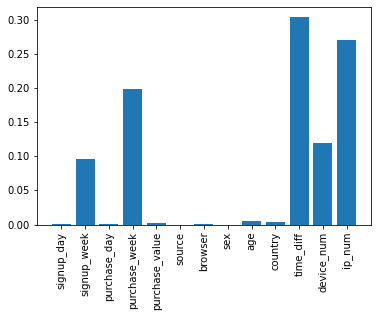

In [19]:
plt.bar(X.columns, features_importances, align='center')
plt.xticks(rotation='vertical')

### Afficher le `Classification report`

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41177
           1       1.00      0.55      0.71      4157

   micro avg       0.96      0.96      0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



### Traçer la courbe AUC 

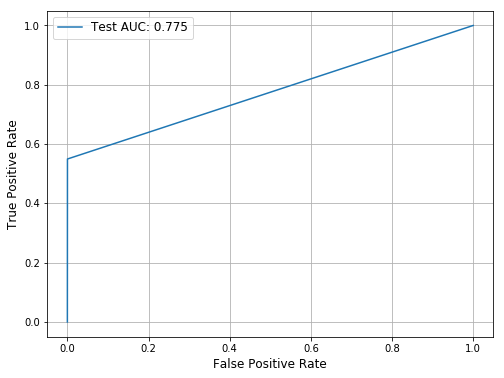

### Afficher la matrice de confusion 
Qu'en pensez vous ? 

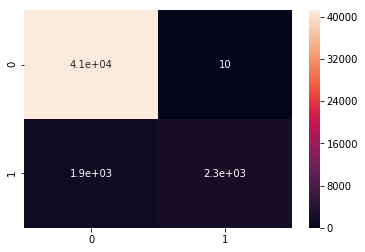

### Faire une selection de certaine variables et spliter vos varibales 

Shape du dataset d'entrainement : (105778, 4) | Shape du dataset de test : (45334, 4)


### Entrainer un classifieur `LogisticRegression` sur ces variables 

L'accuracy moyenne pour 10 'fold cross validation' est 95.39%
